# Question 2 : pastorales et pièces d'inspiration pastorale

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.test.utils import datapath
mallet_path = 'mallet-2.0.8/bin/mallet'

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import philocomp as phc

## Délimitation du corpus

In [2]:
df = pd.read_csv('corpora/all_VER_NOM_ADJqua_ok.csv')

corp = df[df['id_piece'].isin([
                                # Pastorales
                                'BOYER_LISIMENE',
                                'CORNEILLET_BERGEREXTRAVAGANT',
                                'DONNEAUDEVISE_AMOURSDUSOLEIL',
                                'DONNEAUDEVISE_DELIE',
                                'POUSSETDEMONTAUBAN_FELICIE',
                                'QUINAULT_FETESAMOURBACCHUS',
                                'ROTROU_AMARILLIS',
                                'ROTROU_CLEAGENOR',
                                # Pastorales héroïques
                                'CAMPISTRON_ACISGALATHEE',
                                'URFE_SYLVANIRE',
                                # Eglogues
                                'QUINAULT_GROTTE',
                                'QUINAULT_TEMPLEDELAPAIX',

                                # Inspiration pastorale',
                                'DISCRET_NOCESDEVAUGIRARD',
                                'LAFONTAINE_ASTREE',
                                'MOLIERE_MELICERTE',
                                'QUINAULT_GENEREUSEINGRATITUDE',
                                'RAYSSIGUIER_PALINICE',
                                'ROTROU_ANTIGONE',
                                'ROTROU_BAGUEDELOUBLI',
                                'ROTROU_CELIANE'
                              ])]

# on ne garde que les lignes comprenant au moins 700 lemmes :
corp = corp[corp['nlemmes'] > 700]

# on calcule le nombre de lemmes pour chacun des genres :
pd.pivot_table(corp, index=['genre'],
               values=['nlemmes', 'id_piece'],
               aggfunc={'nlemmes': np.sum,
                        'id_piece': 'count'})

,id_piece,nlemmes
genre,,
Comédie,16,12800
Comédie héroïque,2,1600
Pastorale,48,38392
Pastorale héroïque,26,20800
Tragi-comédie,21,16800
Tragédie,17,13600
Tragédie lyrique,3,2400
Églogue,1,800


In [3]:
# on calcule le nombre de lemmes pour chacun des genres et pièces :
pd.pivot_table(corp, index=['genre', 'titre'],
               values=['nlemmes', 'id_piece'],
               aggfunc={'nlemmes': np.sum,
                        'id_piece': 'count'})

id_piece  \
genre              titre                                                          
Comédie            LA BAGUE DE L'OUBLI, COMÉDIE                               7   
                   LES NOCES DE VAUGIRARD, OU LES NAÏVETÉS CHAMPÊT...         9   
Comédie héroïque   MÉLICERTE, COMÉDIE PASTORALE HÉROÏQUE                      2   
Pastorale          AMARILLIS, PASTORALE.                                      6   
                   CLÉAGÉNOR et DORISTÉE, TRAGI-COMÉDIE.                      8   
                   DÉLIE, PASTORALE.                                          7   
                   LE BERGER EXTRAVAGANT, PASTORALE BURLESQUE.                9   
                   LES CHARMES DE FÉLICIE, TIRÉS DE LA DIANE DE MO...         8   
                   LES FÊTES DE L'AMOUR ET DE BACCHUS, PASTORALE              2   
                   LISIMÈNE OU LA JEUNE BERGÈRE, PASTORALE                    8   
Pastorale héroïque ACIS ET GALATÉE, PASTORALE HÉROÏQUE                        2   
                   SYLVANIRE ou la MORTE VIVE, FABLE BOCAGÈRE                24   
Tragi-comédie      LA CÉLIANE, TRAGI-COMÉDIE                                  8   
                   LA GÉNÉREUSE INGRATITUDE, TRAGI-COMÉDIE PASTORALE          7   
                   PALINICE, CIRCEINE ET FLORICE, TRAGI-COMÉDIE PA...         6   
Tragédie           ANTIGONE, TRAGÉDIE                                         8   
                   LES AMOURS DU SOLEIL, PASTORALE.                           9   
Tragédie lyrique   ASTRÉE, TRAGÉDIE                                           3   
Églogue            LE TEMPLE DE LA PAIX, BALLET                               1   

                                                                       nlemmes  
genre              titre                                                        
Comédie            LA BAGUE DE L'OUBLI, COMÉDIE                           5600  
                   LES NOCES DE VAUGIRARD, OU LES NAÏVETÉS CHAMPÊT...     7200  
Comédie héroïque   MÉLICERTE, COMÉDIE PASTORALE HÉROÏQUE                  1600  
Pastorale          AMARILLIS, PASTORALE.                                  4800  
                   CLÉAGÉNOR et DORISTÉE, TRAGI-COMÉDIE.                  6400  
                   DÉLIE, PASTORALE.                                      5592  
                   LE BERGER EXTRAVAGANT, PASTORALE BURLESQUE.            7200  
                   LES CHARMES DE FÉLICIE, TIRÉS DE LA DIANE DE MO...     6400  
                   LES FÊTES DE L'AMOUR ET DE BACCHUS, PASTORALE          1600  
                   LISIMÈNE OU LA JEUNE BERGÈRE, PASTORALE                6400  
Pastorale héroïque ACIS ET GALATÉE, PASTORALE HÉROÏQUE                    1600  
                   SYLVANIRE ou la MORTE VIVE, FABLE BOCAGÈRE            19200  
Tragi-comédie      LA CÉLIANE, TRAGI-COMÉDIE                              6400  
                   LA GÉNÉREUSE INGRATITUDE, TRAGI-COMÉDIE PASTORALE      5600  
                   PALINICE, CIRCEINE ET FLORICE, TRAGI-COMÉDIE PA...     4800  
Tragédie           ANTIGONE, TRAGÉDIE                                     6400  
                   LES AMOURS DU SOLEIL, PASTORALE.                       7200  
Tragédie lyrique   ASTRÉE, TRAGÉDIE                                       2400  
Églogue            LE TEMPLE DE LA PAIX, BALLET                            800

On constate un certain déséquilibre. On ne tentera pas de le résorber entre genres, mais uniquement entre pièces.

In [4]:
corp.to_excel("corpora/corpus2.xlsx", index=False)

On corrige les déséquilibres (au moins pour la répartition entre genres) en supprimant quelques lignes pour les tragédies et comédies, puis on réimporte le corpus.

In [5]:
corp = pd.read_csv("corpora/corpus2_eq.csv")

On refait ensuite les calculs de répartitions exécutés précedemment.

In [6]:
pd.pivot_table(corp, index=['genre'],
               values=['nlemmes', 'id_piece'],
               aggfunc={'nlemmes': np.sum,
                        'id_piece': 'count'})

,id_piece,nlemmes
genre,,
Inspiration pastorale,47,37600
Pastorale,38,30392
Pastorale héroïque,8,6400
Églogue,1,800


In [7]:
pd.pivot_table(corp, index=['genre', 'titre'],
               values=['nlemmes', 'id_piece'],
               aggfunc={'nlemmes': np.sum,
                        'id_piece': 'count'})

id_piece  \
genre                 titre                                                          
Inspiration pastorale ANTIGONE, TRAGÉDIE                                         6   
                      ASTRÉE, TRAGÉDIE                                           3   
                      LA BAGUE DE L'OUBLI, COMÉDIE                               6   
                      LA CÉLIANE, TRAGI-COMÉDIE                                  6   
                      LA GÉNÉREUSE INGRATITUDE, TRAGI-COMÉDIE PASTORALE          6   
                      LES AMOURS DU SOLEIL, PASTORALE.                           6   
                      LES NOCES DE VAUGIRARD, OU LES NAÏVETÉS CHAMPÊT...         6   
                      MÉLICERTE, COMÉDIE PASTORALE HÉROÏQUE                      2   
                      PALINICE, CIRCEINE ET FLORICE, TRAGI-COMÉDIE PA...         6   
Pastorale             AMARILLIS, PASTORALE.                                      6   
                      CLÉAGÉNOR et DORISTÉE, TRAGI-COMÉDIE.                      6   
                      DÉLIE, PASTORALE.                                          6   
                      LE BERGER EXTRAVAGANT, PASTORALE BURLESQUE.                6   
                      LES CHARMES DE FÉLICIE, TIRÉS DE LA DIANE DE MO...         6   
                      LES FÊTES DE L'AMOUR ET DE BACCHUS, PASTORALE              2   
                      LISIMÈNE OU LA JEUNE BERGÈRE, PASTORALE                    6   
Pastorale héroïque    ACIS ET GALATÉE, PASTORALE HÉROÏQUE                        2   
                      SYLVANIRE ou la MORTE VIVE, FABLE BOCAGÈRE                 6   
Églogue               LE TEMPLE DE LA PAIX, BALLET                               1   

                                                                          nlemmes  
genre                 titre                                                        
Inspiration pastorale ANTIGONE, TRAGÉDIE                                     4800  
                      ASTRÉE, TRAGÉDIE                                       2400  
                      LA BAGUE DE L'OUBLI, COMÉDIE                           4800  
                      LA CÉLIANE, TRAGI-COMÉDIE                              4800  
                      LA GÉNÉREUSE INGRATITUDE, TRAGI-COMÉDIE PASTORALE      4800  
                      LES AMOURS DU SOLEIL, PASTORALE.                       4800  
                      LES NOCES DE VAUGIRARD, OU LES NAÏVETÉS CHAMPÊT...     4800  
                      MÉLICERTE, COMÉDIE PASTORALE HÉROÏQUE                  1600  
                      PALINICE, CIRCEINE ET FLORICE, TRAGI-COMÉDIE PA...     4800  
Pastorale             AMARILLIS, PASTORALE.                                  4800  
                      CLÉAGÉNOR et DORISTÉE, TRAGI-COMÉDIE.                  4800  
                      DÉLIE, PASTORALE.                                      4792  
                      LE BERGER EXTRAVAGANT, PASTORALE BURLESQUE.            4800  
                      LES CHARMES DE FÉLICIE, TIRÉS DE LA DIANE DE MO...     4800  
                      LES FÊTES DE L'AMOUR ET DE BACCHUS, PASTORALE          1600  
                      LISIMÈNE OU LA JEUNE BERGÈRE, PASTORALE                4800  
Pastorale héroïque    ACIS ET GALATÉE, PASTORALE HÉROÏQUE                    1600  
                      SYLVANIRE ou la MORTE VIVE, FABLE BOCAGÈRE             4800  
Églogue               LE TEMPLE DE LA PAIX, BALLET                            800

## Elimination des lemmes les plus fréquents

Le corpus ne comprend que des lemmes de noms (communs ou propres), verbes et adjectifs qualificatifs. On peut donc considérer qu'une partie non négligeable des lemmes les plus fréquents (déterminants, pronoms, adverbes) a été éliminée.
On établit toutefois une liste des lemmes, du plus au moins fréquent, afin de procéder à de nouvelles éliminations.

In [8]:
corp_lemmas = phc.get_lemmas(corp)
corp_lemmas_freq = phc.get_freq_lemmas(corp_lemmas, 25)
corp_lemmas_freq

,lemma,freq,cum_freq
0,être,4654,6.189488
1,avoir,2999,10.177944
2,faire,1547,12.235344
3,pouvoir,1327,14.000160
4,voir,1199,15.594744
5,amour,1015,16.944622
6,aimer,714,17.894191
7,vouloir,694,18.817161
8,savoir,684,19.726833
9,devoir,619,20.550059


Après différents tests, on considère qu'en deçà de 25 % de fréquence cumulée les termes ne sont pas très signifiant pour la constitution des thèmes.

On crée donc une liste de lemmes à exclure à partir de ceux-ci et on les supprime du corpus.

In [9]:
stop_words_list = corp_lemmas_freq['lemma'].to_list()

In [10]:
corp['lemmes_sans_stop_words'] = corp['lemmes'].apply(lambda text: phc.remove_stop_words(text, stop_words_list))
corp['nlemmes_sans_stop_words'] = corp['lemmes_sans_stop_words'].apply(lambda x : len(x.split()))

On vérifie que cette suppression de lemmes ne crée pas un nouveau déséquilibre trop important entre genres.

In [11]:
pd.pivot_table(corp, index=['genre'],
               values=['nlemmes', 'nlemmes_sans_stop_words'],
               aggfunc=np.sum)

,nlemmes,nlemmes_sans_stop_words
genre,,
Inspiration pastorale,37600,28422
Pastorale,30392,22694
Pastorale héroïque,6400,4748
Églogue,800,602


## Extraction des thèmes

On recourt un modèle d'allocation de Dirichlet latente pour l'extraction des thèmes.

On utilise ici l'[API Python](https://radimrehurek.com/gensim/models/wrappers/ldamallet.html) proposée par le module Gensim pour le modèle [LDA MALLET](http://mallet.cs.umass.edu/topics.php).

### Transformation des données

In [12]:
data = corp['lemmes_sans_stop_words'].str.split().to_list()
id2word = corpora.Dictionary(data)
corpus = [id2word.doc2bow(text) for text in data]

### Recherche du nombre de thèmes optimal

On lance des tests entre 2 et 20 thèmes pour obtenir la perplexité et la cohérence et déterminer le meilleur nombre de thèmes.

In [0]:
for k in range(2,21,1):
    mallet_model = gensim.models.wrappers.LdaMallet(mallet_path,
                                                    corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=k,
                                                    iterations=10,
                                                    random_seed=5
                                                    )
    lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet_model)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(f"k = {k} : coherence_lda = {coherence_lda}")

k = 2 : coherence_lda = 0.22124590518500867
k = 3 : coherence_lda = 0.22155063100112274
k = 4 : coherence_lda = 0.23277903549884588
k = 5 : coherence_lda = 0.22427442586995233
k = 6 : coherence_lda = 0.23235787832909494
k = 7 : coherence_lda = 0.23781064126361537
k = 8 : coherence_lda = 0.24582778748647768
k = 9 : coherence_lda = 0.25252867793275957
k = 10 : coherence_lda = 0.24183255278691057
k = 11 : coherence_lda = 0.24387503124061596
k = 12 : coherence_lda = 0.2499211122365319
k = 13 : coherence_lda = 0.23997670055078624
k = 14 : coherence_lda = 0.24700395910385117
k = 15 : coherence_lda = 0.24398939641850806
k = 16 : coherence_lda = 0.2633837443268441
k = 17 : coherence_lda = 0.23432504501144671
k = 18 : coherence_lda = 0.2482759533500152
k = 19 : coherence_lda = 0.24727755186310033
k = 20 : coherence_lda = 0.2537076176577834


Apparemment, Gensim ne permet pas de récupérer simplement la perplexité pour LDA MALLET.
On retrouve toutefois celle-ci dans les logs de la sortie standard, dont on propose ici une copie simplifiée.
La perplexité correspond à la valeur de 'LL/token'.

Mallet LDA: 2 topics, 1 topic bits, 1 topic mask
<10> LL/token: -8,08846

Mallet LDA: 3 topics, 2 topic bits, 11 topic mask
<10> LL/token: -8,38031

Mallet LDA: 4 topics, 2 topic bits, 11 topic mask
<10> LL/token: -8,53995

Mallet LDA: 5 topics, 3 topic bits, 111 topic mask
<10> LL/token: -8,65697

Mallet LDA: 6 topics, 3 topic bits, 111 topic mask
<10> LL/token: -8,71785

Mallet LDA: 7 topics, 3 topic bits, 111 topic mask
<10> LL/token: -8,82888

Mallet LDA: 8 topics, 3 topic bits, 111 topic mask
<10> LL/token: -8,85231

Mallet LDA: 9 topics, 4 topic bits, 1111 topic mask
<10> LL/token: -8,9143

Mallet LDA: 10 topics, 4 topic bits, 1111 topic mask
<10> LL/token: -8,95465

Mallet LDA: 11 topics, 4 topic bits, 1111 topic mask
<10> LL/token: -8,99482

Mallet LDA: 12 topics, 4 topic bits, 1111 topic mask
<10> LL/token: -9,01905

Mallet LDA: 13 topics, 4 topic bits, 1111 topic mask
<10> LL/token: -9,07482

Mallet LDA: 14 topics, 4 topic bits, 1111 topic mask
<10> LL/token: -9,07789

Mallet LDA: 15 topics, 4 topic bits, 1111 topic mask
<10> LL/token: -9,12308

Mallet LDA: 16 topics, 4 topic bits, 1111 topic mask
<10> LL/token: -9,12472

Mallet LDA: 17 topics, 5 topic bits, 11111 topic mask
<10> LL/token: -9,18241

Mallet LDA: 18 topics, 5 topic bits, 11111 topic mask
<10> LL/token: -9,18698

Mallet LDA: 19 topics, 5 topic bits, 11111 topic mask
<10> LL/token: -9,17678

Mallet LDA: 20 topics, 5 topic bits, 11111 topic mask
<10> LL/token: -9,19562


À partir des taux de cohérence calculés, il est difficile de choisir un nombre de sujets. On lance donc manuellement le modèle sur 3, 5, 7 et 9 sujets. Aucun ne donne de résultat probant et surtout cohérent (deux pièces seront proches pour un modèle, éloignées pour d'autres). On présente donc ici les résultats uniquement pour un modèle à cinq sujets.

### Modèle à 5 sujets

In [13]:
mallet_model5 = gensim.models.wrappers.LdaMallet(mallet_path,
                                             corpus=corpus,
                                             id2word=id2word,
                                             num_topics=5,
                                             iterations=20,
                                             random_seed=5
                                            )
lda_model5 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet_model5)

#### Termes proposés par le modèle

On affiche les termes qui composent les thèmes proposés par le modèle.

In [14]:
phc.print_topics(lda_model5)

Thème : th_01
mots : 0.017*"mort" + 0.014*"dieu" + 0.009*"vivre" + 0.009*"ciel" + 0.008*"mourir" + 0.008*"falloir" + 0.008*"beauté" + 0.007*"esprit" + 0.007*"dessein" + 0.007*"berger"

Thème : th_02
mots : 0.013*"doux" + 0.012*"lieu" + 0.011*"rendre" + 0.009*"plaire" + 0.009*"amant" + 0.009*"toucher" + 0.008*"paraître" + 0.008*"jour" + 0.008*"secret" + 0.007*"seul"

Thème : th_03
mots : 0.013*"âme" + 0.011*"dieu" + 0.010*"bon" + 0.009*"humeur" + 0.009*"esprit" + 0.008*"trouver" + 0.008*"prendre" + 0.008*"parler" + 0.008*"vrai" + 0.007*"mal"

Thème : th_04
mots : 0.011*"falloir" + 0.010*"nom" + 0.009*"amant" + 0.008*"ingrat" + 0.008*"peine" + 0.008*"hymen" + 0.008*"crime" + 0.007*"sembler" + 0.006*"souffrir" + 0.006*"frère"

Thème : th_05
mots : 0.014*"parler" + 0.014*"berger" + 0.011*"jour" + 0.011*"Dieu" + 0.010*"donner" + 0.009*"feu" + 0.009*"grand" + 0.009*"rendre" + 0.009*"cruel" + 0.008*"suivre"



#### Visualisation LDAvis

On poursuit l'interprétation grâce à une visualisation 'LDAvis'.

In [15]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model5, corpus, id2word, sort_topics=False)
vis

/home/fpichenot/app/miniconda3/envs/gensim/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/home/fpichenot/app/miniconda3/envs/gensim/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/home/fpichenot/app/miniconda3/envs/gensim/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.208647  0.173308       1        1  19.135457
1     -0.173225 -0.111749       2        1  19.616587
2      0.187597 -0.206732       3        1  18.928487
3     -0.115117  0.148467       4        1  20.531830
4     -0.107903 -0.003294       5        1  21.787640, topic_info=           Term        Freq       Total Category  logprob  loglift
215        mort  264.000000  264.000000  Default  30.0000  30.0000
683        Dieu  145.000000  145.000000  Default  29.0000  29.0000
1242     humeur  103.000000  103.000000  Default  28.0000  28.0000
39          bon  118.000000  118.000000  Default  27.0000  27.0000
162       hymen   92.000000   92.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
18        amant   87.138886  320.912925   Topic5  -4.9501   0.2202
540     trouver   78.124519  214.419981   Topic5  -5.0593   0.5142
264     prendre   85.135694  303.588051   Topic5  -4.9733   0.2524
351         âme   82.130904  341.384266   Topic5  -5.0093   0.0991
71    connaître   69.110151  217.793431   Topic5  -5.1819   0.3760

[526 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3296      1  0.991205   Alcandre
1752      3  0.988664     Arabie
1984      2  0.992714    Bacchus
362       4  1.001940      Diane
683       2  0.096344       Dieu
...     ...       ...        ...
1750      3  0.988664    étendre
1076      1  0.991205    éternel
2180      4  1.001940  événement
361       2  0.299746       ôter
361       4  0.699408       ôter

[835 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

#### Nombre de documents par thèmes, genres et pièces

In [16]:
main_topic_by_doc_5 = phc.get_main_topic_by_doc(lda_model5, corpus, corp)
pd.pivot_table(main_topic_by_doc_5, index=['thème', 'genre', 'id_piece'],
               values=['indice_doc'],
               aggfunc='count')

indice_doc
thème genre                 id_piece                                 
th_01 Inspiration pastorale ROTROU_ANTIGONE                         4
                            ROTROU_BAGUEDELOUBLI                    2
                            ROTROU_CELIANE                          2
      Pastorale             ROTROU_CLEAGENOR                        2
      Pastorale héroïque    URFE_SYLVANIRE                          6
th_02 Inspiration pastorale LAFONTAINE_ASTREE                       2
                            ROTROU_CELIANE                          3
      Pastorale             CORNEILLET_BERGEREXTRAVAGANT            5
                            QUINAULT_FETESAMOURBACCHUS              1
                            ROTROU_AMARILLIS                        2
                            ROTROU_CLEAGENOR                        2
      Pastorale héroïque    CAMPISTRON_ACISGALATHEE                 1
th_03 Inspiration pastorale DISCRET_NOCESDEVAUGIRARD                6
                            RAYSSIGUIER_PALINICE                    6
                            ROTROU_BAGUEDELOUBLI                    4
                            ROTROU_CELIANE                          1
      Pastorale             ROTROU_AMARILLIS                        4
                            ROTROU_CLEAGENOR                        1
th_04 Inspiration pastorale MOLIERE_MELICERTE                       1
                            QUINAULT_GENEREUSEINGRATITUDE           1
                            ROTROU_ANTIGONE                         2
      Pastorale             BOYER_LISIMENE                          4
                            POUSSETDEMONTAUBAN_FELICIE              6
                            ROTROU_CLEAGENOR                        1
th_05 Inspiration pastorale DONNEAUDEVISE_AMOURSDUSOLEIL            6
                            LAFONTAINE_ASTREE                       1
                            MOLIERE_MELICERTE                       1
                            QUINAULT_GENEREUSEINGRATITUDE           5
      Pastorale             BOYER_LISIMENE                          2
                            CORNEILLET_BERGEREXTRAVAGANT            1
                            DONNEAUDEVISE_DELIE                     6
                            QUINAULT_FETESAMOURBACCHUS              1
      Pastorale héroïque    CAMPISTRON_ACISGALATHEE                 1
      Églogue               QUINAULT_TEMPLEDELAPAIX                 1

#### Contribution (en pourcentage) de chaque thème à chacune des pièces classées par genre

In [17]:
topics_contrib_by_doc_5 = phc.get_topics_contrib_by_doc(lda_model5, corpus, corp)
pd.pivot_table(topics_contrib_by_doc_5, index=['genre', 'id_piece'],
               columns=['thème'],
               values=['prc_contribution'],
               aggfunc='mean')

prc_contribution  \
thème                                                          th_01   
genre                 id_piece                                         
Inspiration pastorale DISCRET_NOCESDEVAUGIRARD             17.946667   
                      DONNEAUDEVISE_AMOURSDUSOLEIL         10.130000   
                      LAFONTAINE_ASTREE                    17.836667   
                      MOLIERE_MELICERTE                    11.750000   
                      QUINAULT_GENEREUSEINGRATITUDE        14.923333   
                      RAYSSIGUIER_PALINICE                 19.551667   
                      ROTROU_ANTIGONE                      28.720000   
                      ROTROU_BAGUEDELOUBLI                 23.855000   
                      ROTROU_CELIANE                       22.051667   
Pastorale             BOYER_LISIMENE                       15.180000   
                      CORNEILLET_BERGEREXTRAVAGANT         17.475000   
                      DONNEAUDEVISE_DELIE                  10.810000   
                      POUSSETDEMONTAUBAN_FELICIE           15.275000   
                      QUINAULT_FETESAMOURBACCHUS           16.260000   
                      ROTROU_AMARILLIS                     15.953333   
                      ROTROU_CLEAGENOR                     21.691667   
Pastorale héroïque    CAMPISTRON_ACISGALATHEE              11.845000   
                      URFE_SYLVANIRE                       39.791667   
Églogue               QUINAULT_TEMPLEDELAPAIX               9.710000   

                                                                           \
thème                                                    th_02      th_03   
genre                 id_piece                                              
Inspiration pastorale DISCRET_NOCESDEVAUGIRARD       16.201667  31.636667   
                      DONNEAUDEVISE_AMOURSDUSOLEIL   20.418333  12.601667   
                      LAFONTAINE_ASTREE              30.966667   9.646667   
                      MOLIERE_MELICERTE              20.535000  20.930000   
                      QUINAULT_GENEREUSEINGRATITUDE  16.540000  11.123333   
                      RAYSSIGUIER_PALINICE           12.956667  35.505000   
                      ROTROU_ANTIGONE                13.708333  19.326667   
                      ROTROU_BAGUEDELOUBLI           17.703333  27.466667   
                      ROTROU_CELIANE                 25.058333  21.893333   
Pastorale             BOYER_LISIMENE                 18.740000   7.460000   
                      CORNEILLET_BERGEREXTRAVAGANT   28.476667  16.146667   
                      DONNEAUDEVISE_DELIE            23.448333   7.751667   
                      POUSSETDEMONTAUBAN_FELICIE     13.886667  14.041667   
                      QUINAULT_FETESAMOURBACCHUS     30.505000  11.835000   
                      ROTROU_AMARILLIS               23.630000  27.553333   
                      ROTROU_CLEAGENOR               20.775000  24.321667   
Pastorale héroïque    CAMPISTRON_ACISGALATHEE        28.775000   7.660000   
                      URFE_SYLVANIRE                 10.040000  17.590000   
Églogue               QUINAULT_TEMPLEDELAPAIX        17.720000   8.000000   

                                                                           
thème                                                    th_04      th_05  
genre                 id_piece                                             
Inspiration pastorale DISCRET_NOCESDEVAUGIRARD       14.990000  19.225000  
                      DONNEAUDEVISE_AMOURSDUSOLEIL   14.916667  41.933333  
                      LAFONTAINE_ASTREE              17.606667  23.936667  
                      MOLIERE_MELICERTE              24.075000  22.715000  
                      QUINAULT_GENEREUSEINGRATITUDE  26.193333  31.216667  
                      RAYSSIGUIER_PALINICE           13.520000  18.461667  
                      ROTROU_ANTIGONE                25.023333  13.226667  
            

#### Visualisation (carte de chaleur) de la contribution de chaque thème à chacune des pièces

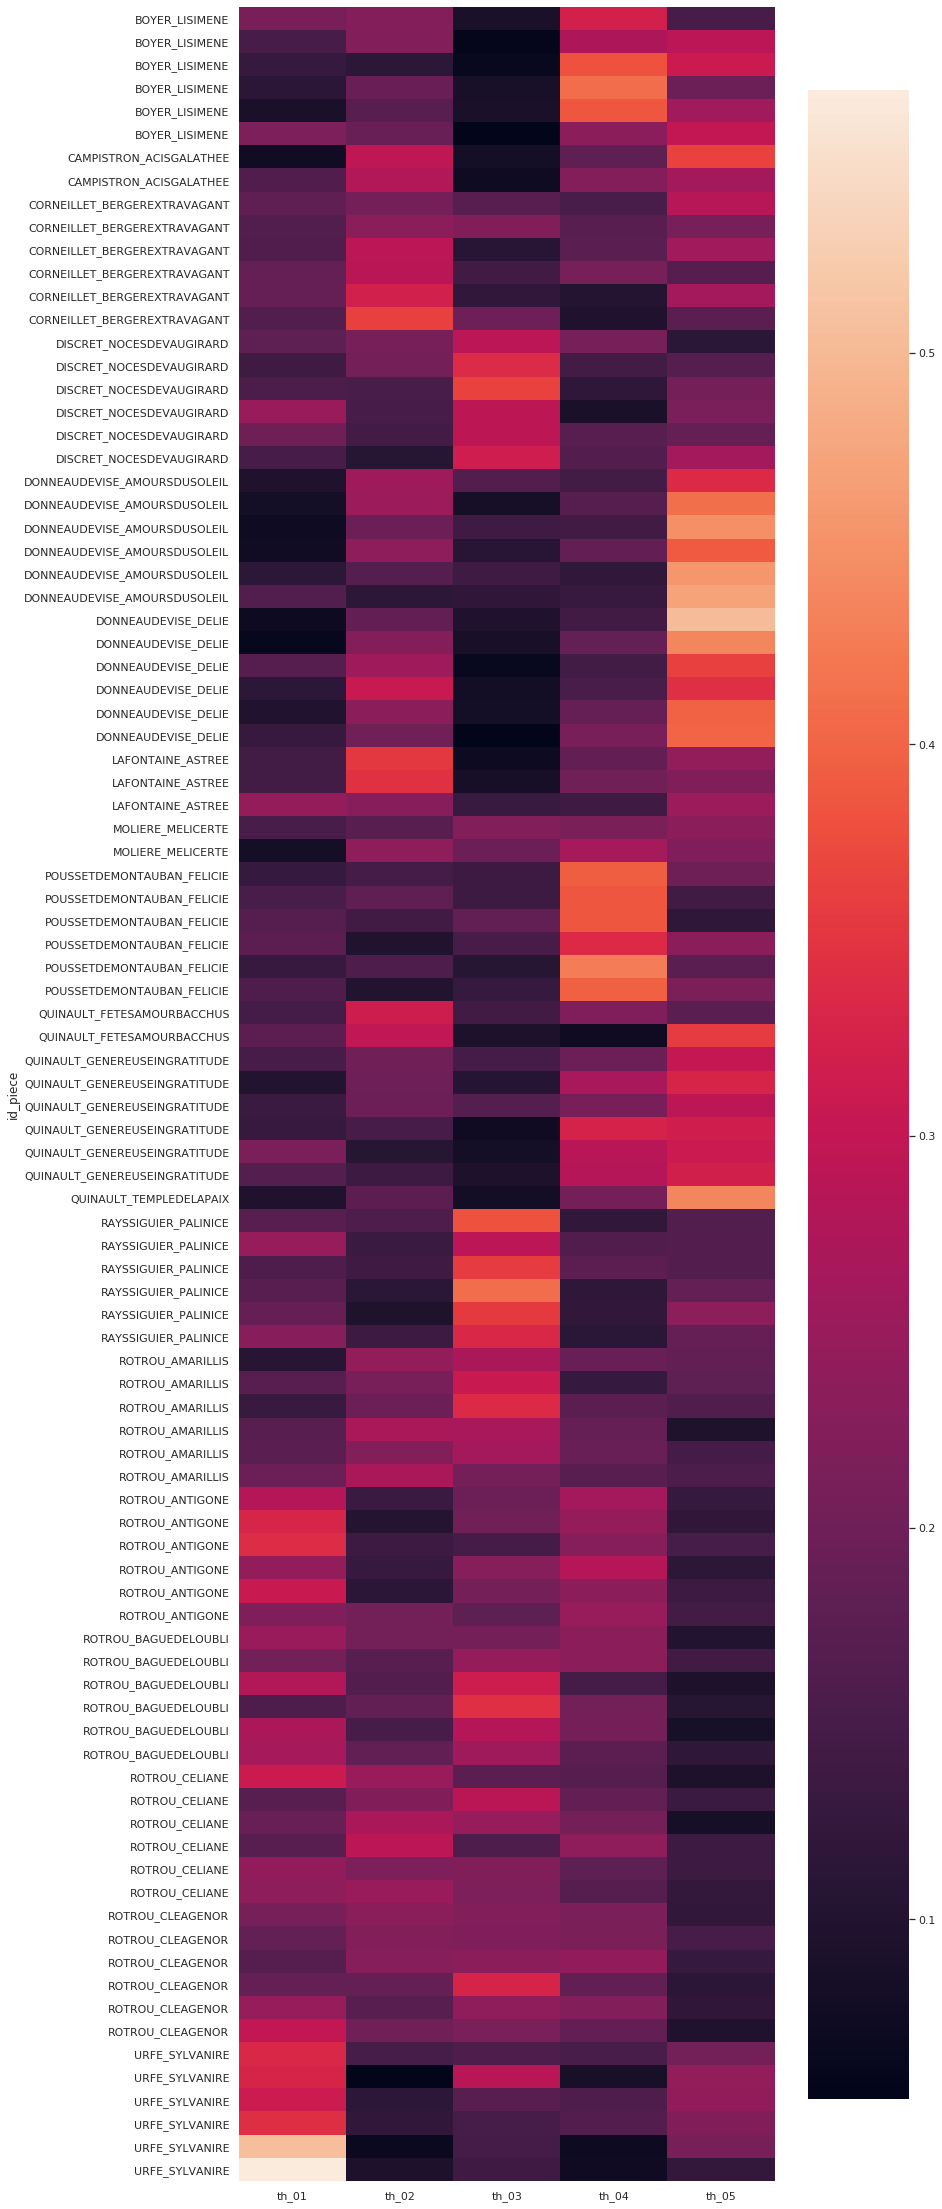

In [20]:
heatmap_df = phc.get_heatmap(lda_model5, 5, corpus, corp, data)
sns.set(rc={'figure.figsize':(12,40)})
sns.heatmap(heatmap_df)

## Conclusion
En dépit de tests sur différents modèles (avec pour variable le nombre de sujets), on ne parvient pas à construire d'ensembles stables permettant de dégager une opposition entre pièces dont le genre est la pastorale et pièces relevant d'une inspiration pastorale mais étant classées dans un genre différent.
Cela laisse à penser la thématique pastorale n'est pas spécifique au genre du même nom, mais plutôt à l'inspiration.

Pour aller plus loin, on pourrait reprendre le corpus précédent (question 1) et essayer de l'étendre de manière systématique aux pièces d'inspiration pastorale.